# MLP手搓实现和FashionMNIST应用

In [222]:
import numpy as np

## 1.Define ActivationFunctions

In [223]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

def sigmoid_backward(dA, X):
    sig = sigmoid(X)
    return dA * sig * (1-sig)

def relu(X):
    return np.maximum(0, X)

def relu_backward(dA, X):
    dX = np.array(dA, copy=True)
    dX[X <= 0] = 0
    return dX

## 2.Initialize parameters & layers

In [224]:
nn_architecture = [
    {"input_dim" : 2, "output_dim" : 4, "activation" : "sigmoid" },
    {"input_dim" : 4, "output_dim" : 6, "activation" : "relu" },
    {"input_dim" : 6, "output_dim" : 4, "activation" : "relu" },
    {"input_dim" : 4, "output_dim" : 2, "activation" : "sigmoid" },
]

In [225]:
def init_layers(nn_architecture, seed=1):
    np.random.seed(seed)
    params_values = {}
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values["W" + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
        params_values["b" + str(layer_idx)] = np.zeros((layer_output_size, 1)) * 0.1
    return params_values
        
    

## 3.Forward Propagation

In [226]:
def layer_forward(A_prev, W_curr, b_curr, activation='relu'):
    if activation == 'sigmoid':
        activation_func = sigmoid
    elif activation == 'relu':
        activation_func = relu
    else:
        raise Exception("Non-supported activation function")
    
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    A_curr = activation_func(Z_curr)
    
    return A_curr, Z_curr

In [227]:
def forward(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        activation_curr = layer["activation"]
        
        A_prev = A_curr
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = layer_forward(A_prev, W_curr, b_curr, activation_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
        
    return A_curr, memory

## 4.Loss Function

In [228]:
def cross_entropy(Y, Y_hat):
    m = Y_hat.shape[1]
    loss = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(loss)

def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
  Y_hat_ = convert_prob_into_class(Y_hat)
  return (Y_hat_ == Y).all(axis=0).mean()

## 5.Backward Propagation

In [229]:
def layer_backward(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if "relu" == activation:
        backward_activation_func = relu_backward
    elif "sigmoid" == activation:
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dW_curr, db_curr, dA_prev

In [230]:
def backward(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
    
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activation_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dW_curr, db_curr, dA_prev = layer_backward(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## 6.Parameters Update

In [231]:
def update_parameters(params_values, grads_values, nn_architecture, lr):
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        params_values["W" + str(layer_idx)] -= lr * grads_values["dW" + str(layer_idx)]
        params_values['b' + str(layer_idx)] -= lr * grads_values["db" + str(layer_idx)]
    return params_values

## 7.Train

In [232]:
def train(X, Y, nn_architecture, epochs, lr, verbose=False, callback=None, params_values=None):
    # 初始化参数
    if params_values is None:
        params_values = init_layers(nn_architecture)
    
    # 初始化loss, accuracy记录
    loss_history = []
    accuracy_history = []
    
    # 训练
    for epoch in range(epochs):
        # 前向传播
        Y_hat, cashe = forward(X, params_values, nn_architecture)
        
        #计算loss, accuracy
        loss = cross_entropy(Y, Y_hat)
        loss_history.append(loss)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # 反向传播
        grads_values = backward(Y_hat, Y, cashe, params_values, nn_architecture)
        
        # 更新参数
        params_values = update_parameters(params_values, grads_values, nn_architecture, lr)
        
        if (epoch + 1) % 300 == 0:
            if(verbose):
                print("Iteration: {:05} - loss: {:.5f} - accuracy: {:.5f}".format(epoch + 1, loss, accuracy))
            if(callback is not None):
                callback(epoch + 1, params_values)
        
    return params_values, loss_history, accuracy_history    

## Example1 : David vs Goliath 

In [233]:
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import accuracy_score

# number of samples in the data set
N_SAMPLES = 5000
# ratio between training and test sets
TEST_SIZE = 0.2
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

X_train.shape

(4000, 2)

In [234]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=True):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

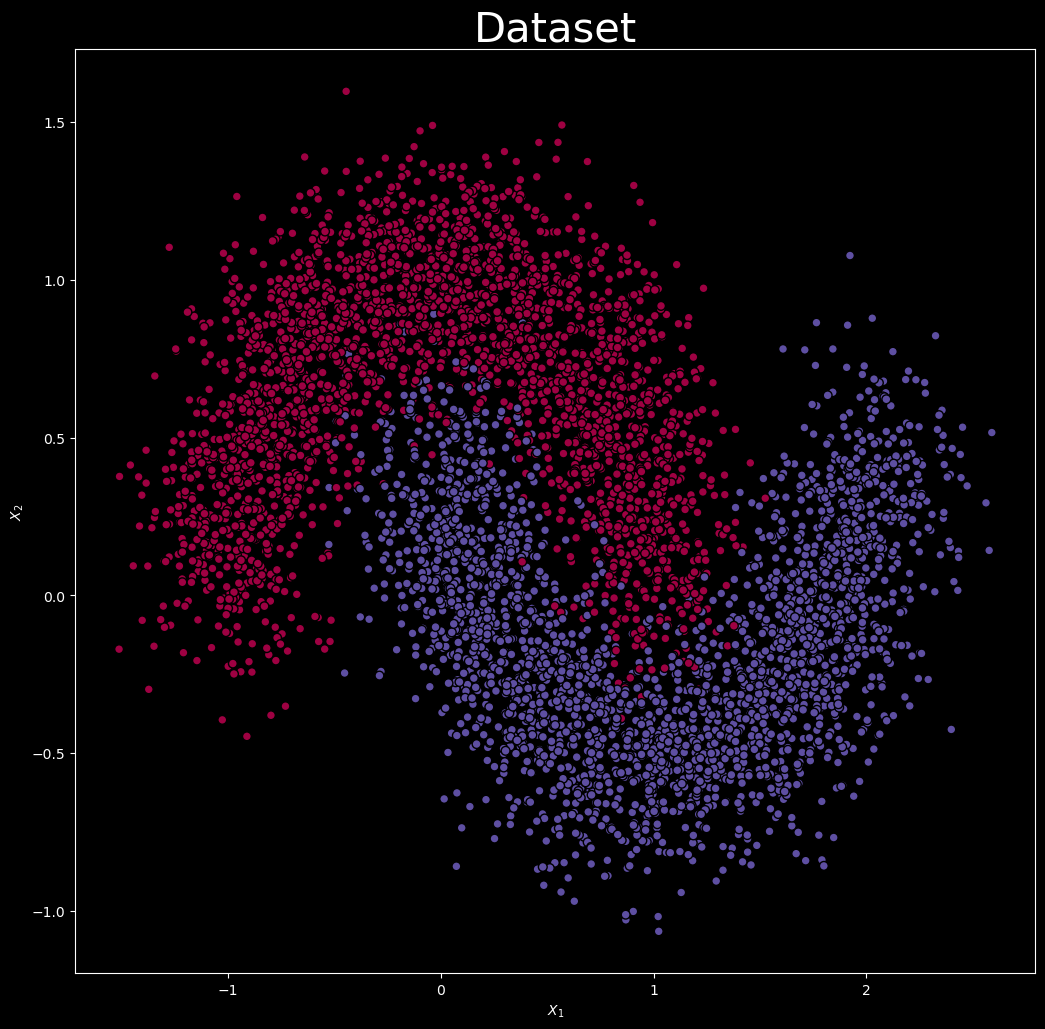

In [235]:
make_plot(X, y, "Dataset")

In [236]:
nn_architecture = [      # adjust the layers to obtain a better accuracy or good convergece history
  {"input_dim": 2, "output_dim": 5, "activation": "relu"},    
  {"input_dim": 5, "output_dim": 8, "activation": "relu"},
  {"input_dim": 8, "output_dim": 8, "activation": "relu"},
  {"input_dim": 8, "output_dim": 4, "activation": "relu"},
  {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

In [324]:
# Training
print(np.transpose(X_train).shape)
params_values, cost_history, accuracy_history = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), nn_architecture, 3600, 0.1,True,None)

(2, 4000)
Iteration: 00300 - loss: 0.69309 - accuracy: 0.50075
Iteration: 00600 - loss: 0.69306 - accuracy: 0.50075
Iteration: 00900 - loss: 0.69300 - accuracy: 0.50075
Iteration: 01200 - loss: 0.69288 - accuracy: 0.50075
Iteration: 01500 - loss: 0.69250 - accuracy: 0.50075
Iteration: 01800 - loss: 0.68913 - accuracy: 0.78400
Iteration: 02100 - loss: 0.32805 - accuracy: 0.87700
Iteration: 02400 - loss: 0.28943 - accuracy: 0.87825
Iteration: 02700 - loss: 0.25479 - accuracy: 0.89625
Iteration: 03000 - loss: 0.09437 - accuracy: 0.97075
Iteration: 03300 - loss: 0.08298 - accuracy: 0.97200
Iteration: 03600 - loss: 0.08021 - accuracy: 0.97125


In [238]:
# Prediction
Y_test_hat, _ = forward(np.transpose(X_test), params_values, nn_architecture)

In [239]:
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} - David".format(acc_test))

Test set accuracy: 0.96 - David


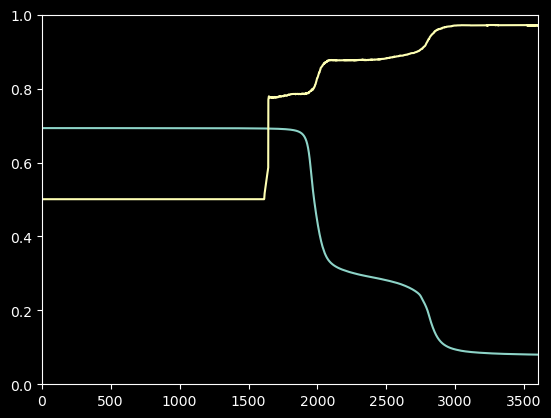

In [240]:
plt.plot(range(len(cost_history)),cost_history)
plt.plot(range(len(accuracy_history)),accuracy_history)
plt.xlim([0,len(cost_history)])
plt.ylim([0,1])
plt.show()

## 可视化

In [241]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

In [242]:
def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
  #  file_name = "numpy_model_{:05}.png".format(index//50)
  #  file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = forward(np.transpose(grid_2d), params, nn_architecture)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=None, XX=XX, YY=YY, preds=prediction_probs, dark=True)

Iteration: 00300 - loss: 0.69309 - accuracy: 0.50075
Iteration: 00600 - loss: 0.69306 - accuracy: 0.50075
Iteration: 00900 - loss: 0.69300 - accuracy: 0.50075
Iteration: 01200 - loss: 0.69288 - accuracy: 0.50075
Iteration: 01500 - loss: 0.69250 - accuracy: 0.50075
Iteration: 01800 - loss: 0.68913 - accuracy: 0.78400
Iteration: 02100 - loss: 0.32805 - accuracy: 0.87700
Iteration: 02400 - loss: 0.28943 - accuracy: 0.87825
Iteration: 02700 - loss: 0.25479 - accuracy: 0.89625
Iteration: 03000 - loss: 0.09437 - accuracy: 0.97075
Iteration: 03300 - loss: 0.08298 - accuracy: 0.97200
Iteration: 03600 - loss: 0.08021 - accuracy: 0.97125
Iteration: 03900 - loss: 0.07886 - accuracy: 0.97100
Iteration: 04200 - loss: 0.07798 - accuracy: 0.97125
Iteration: 04500 - loss: 0.07737 - accuracy: 0.97125


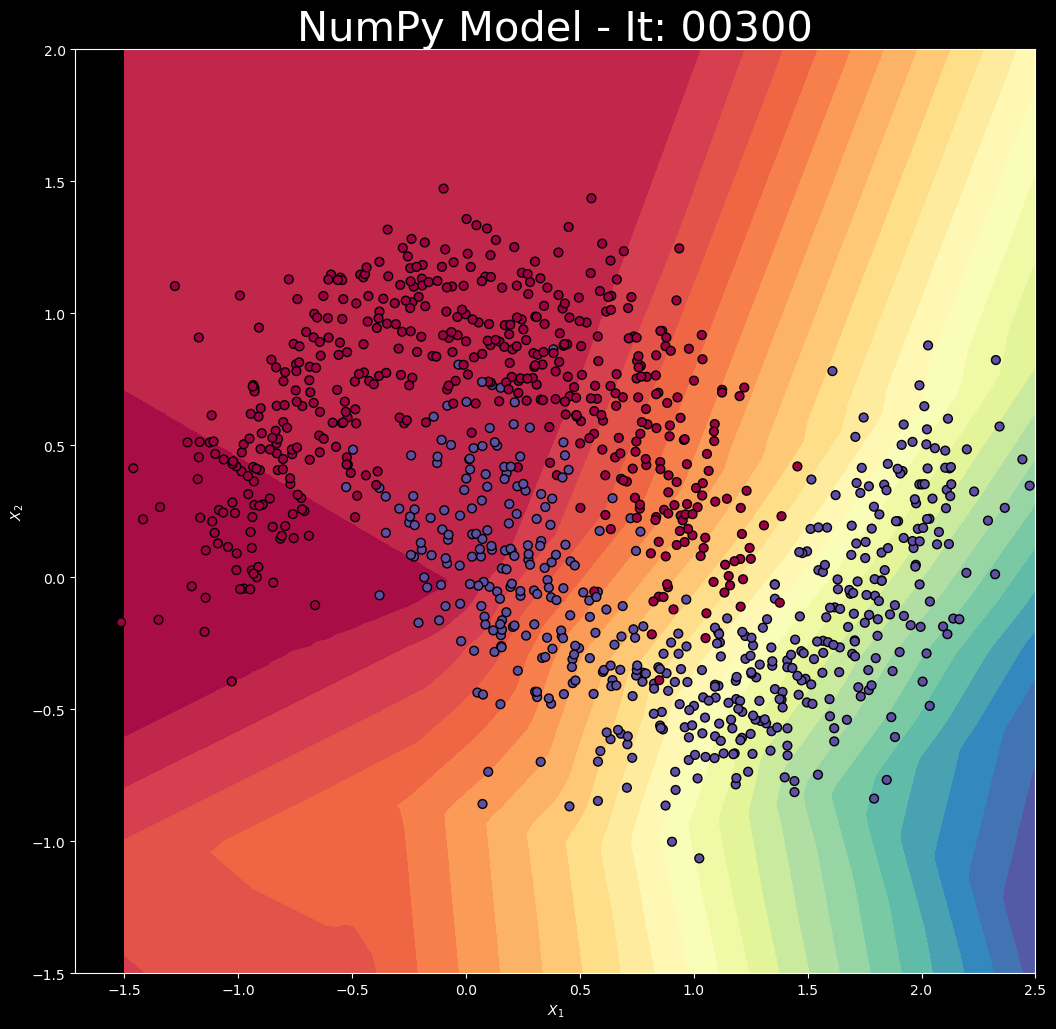

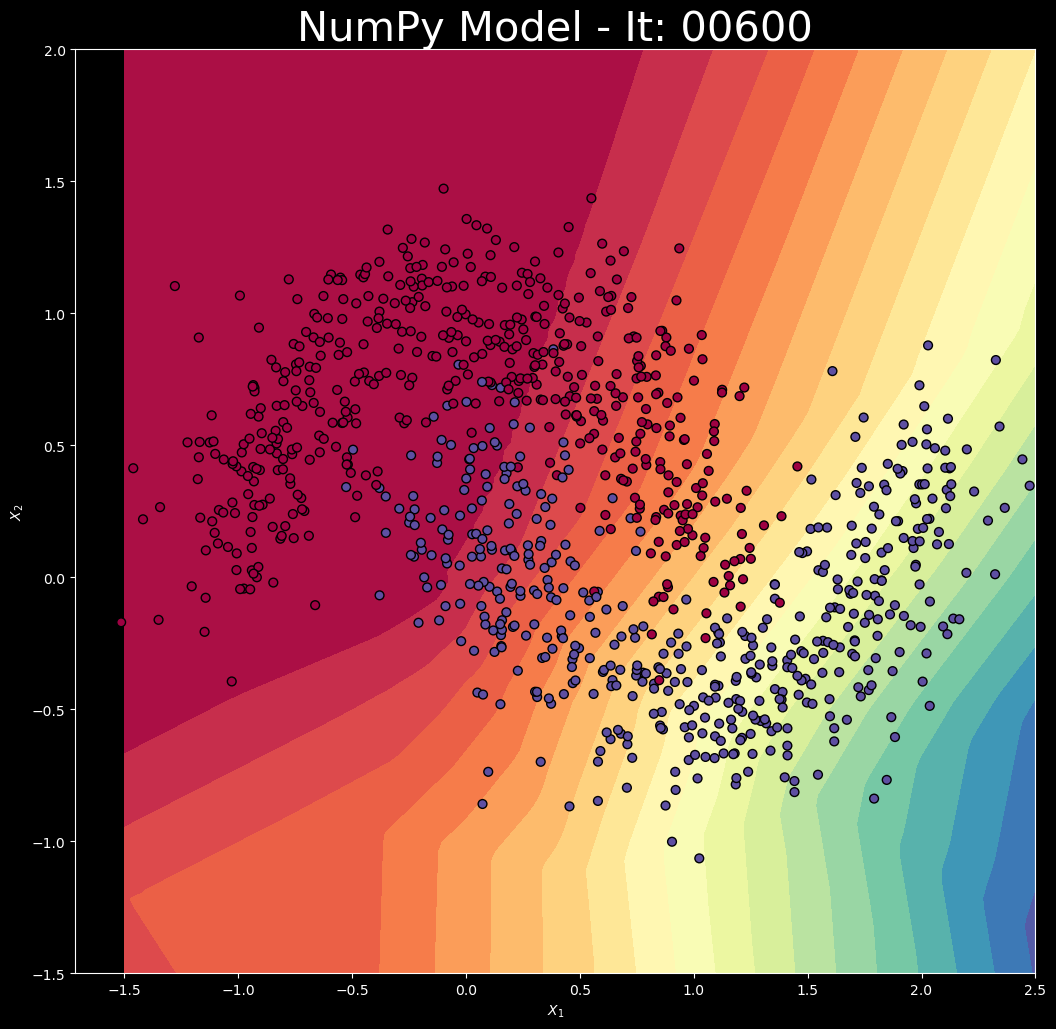

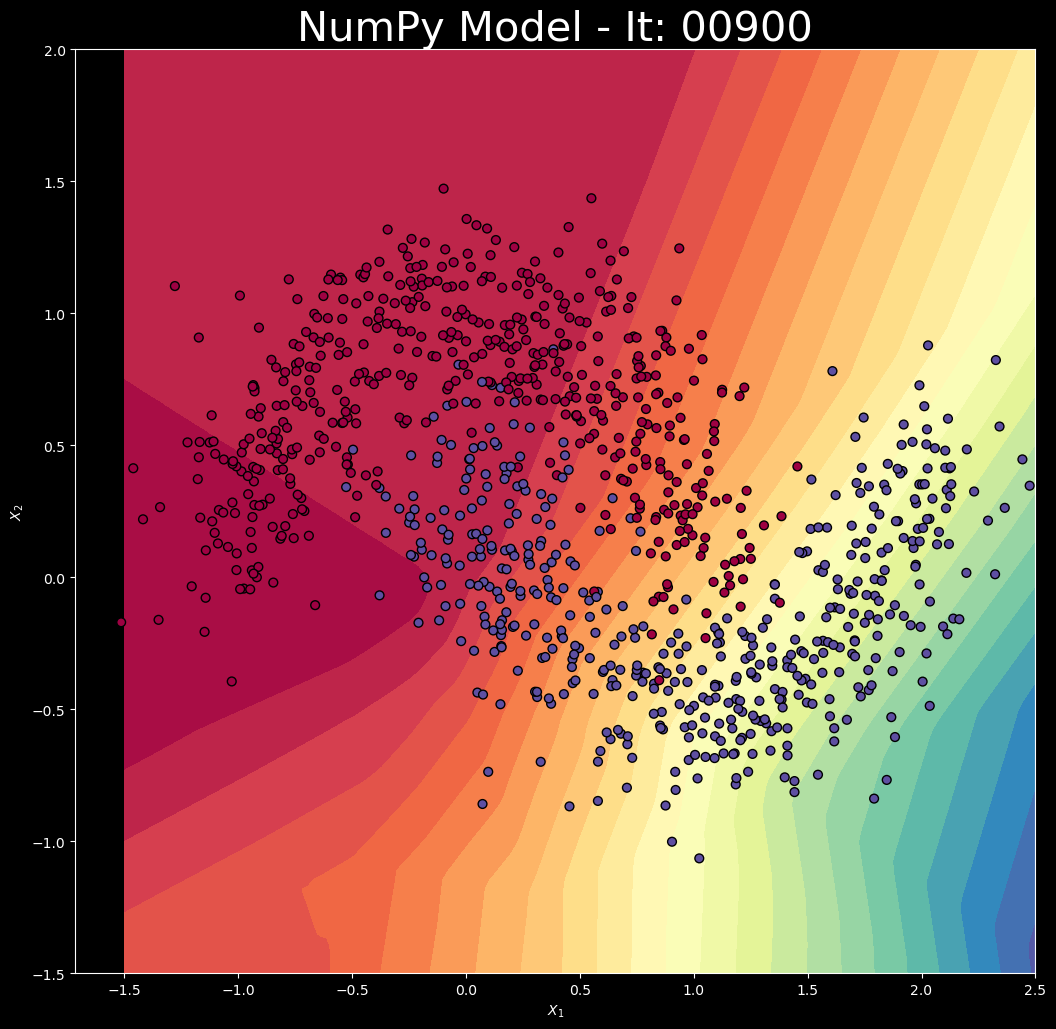

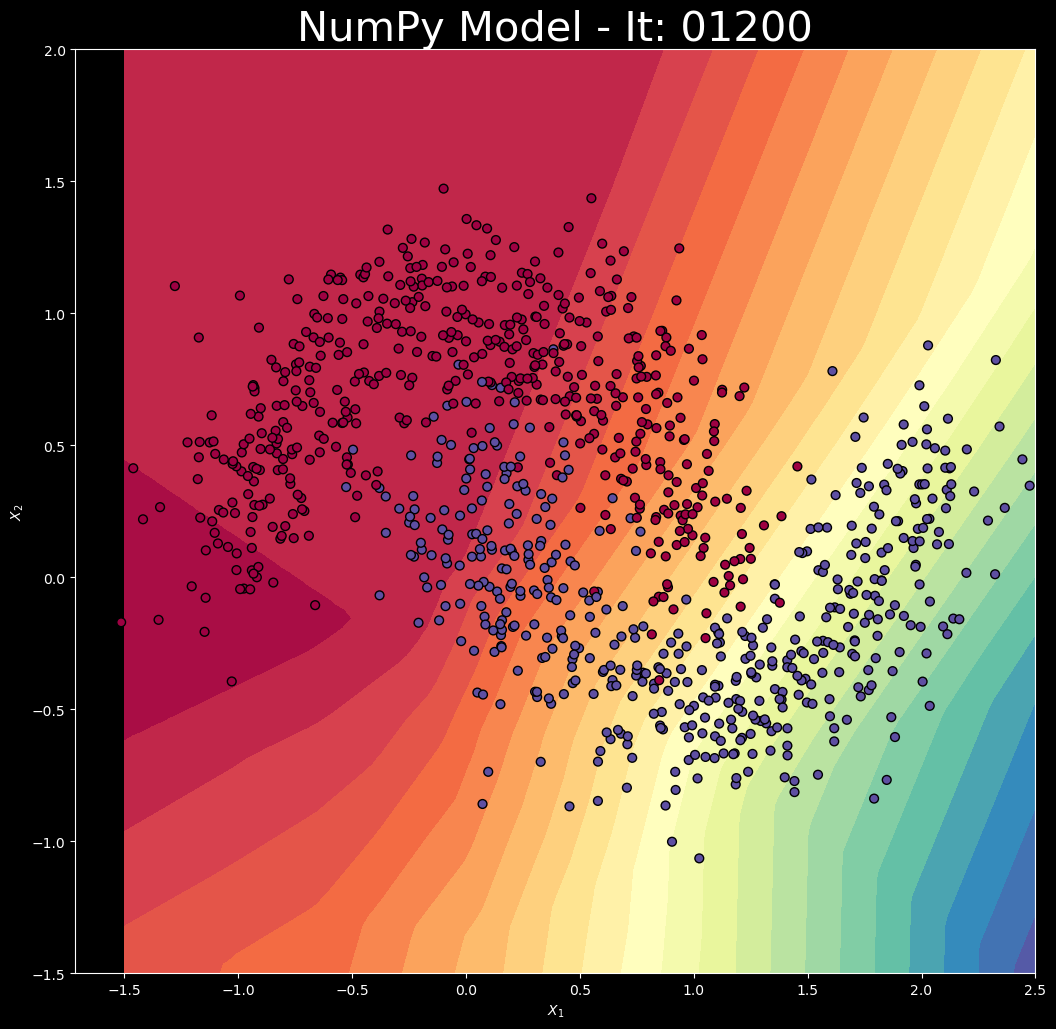

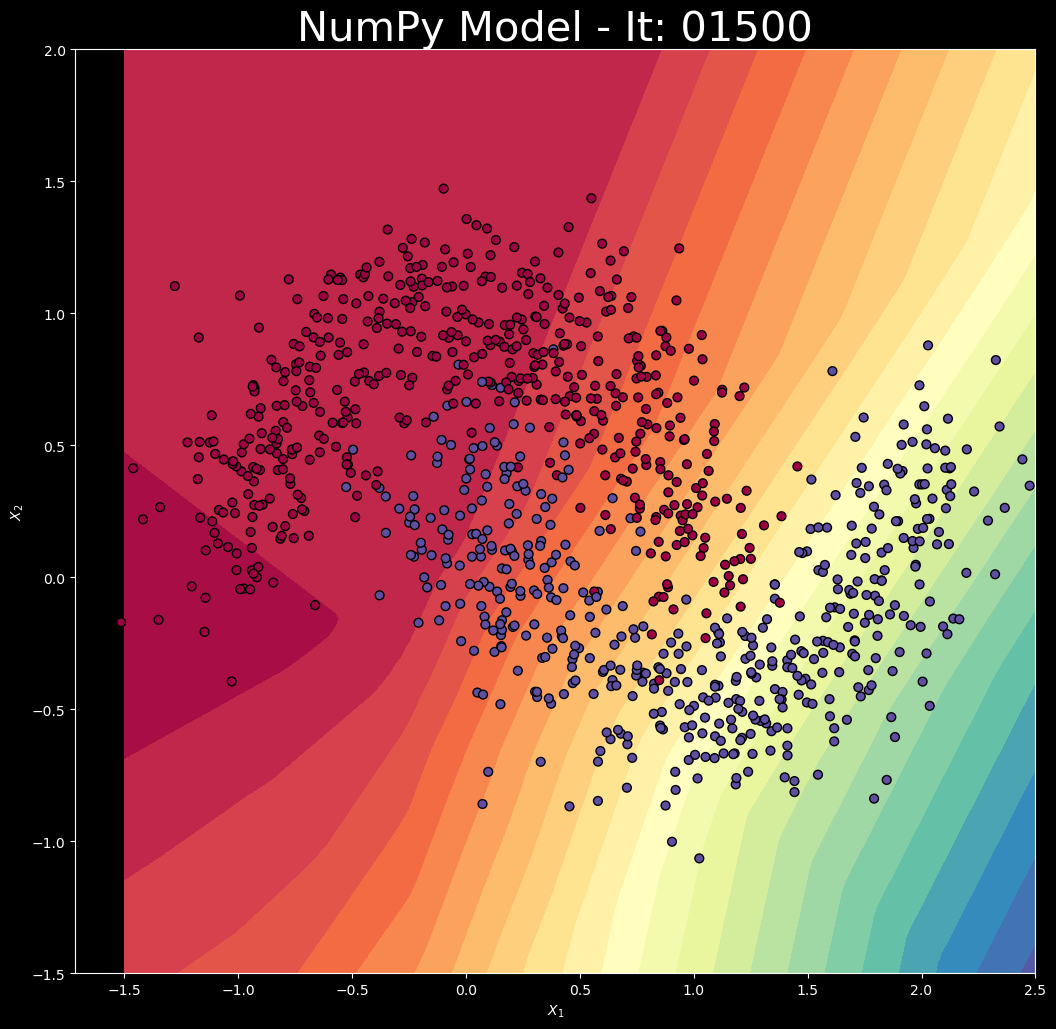

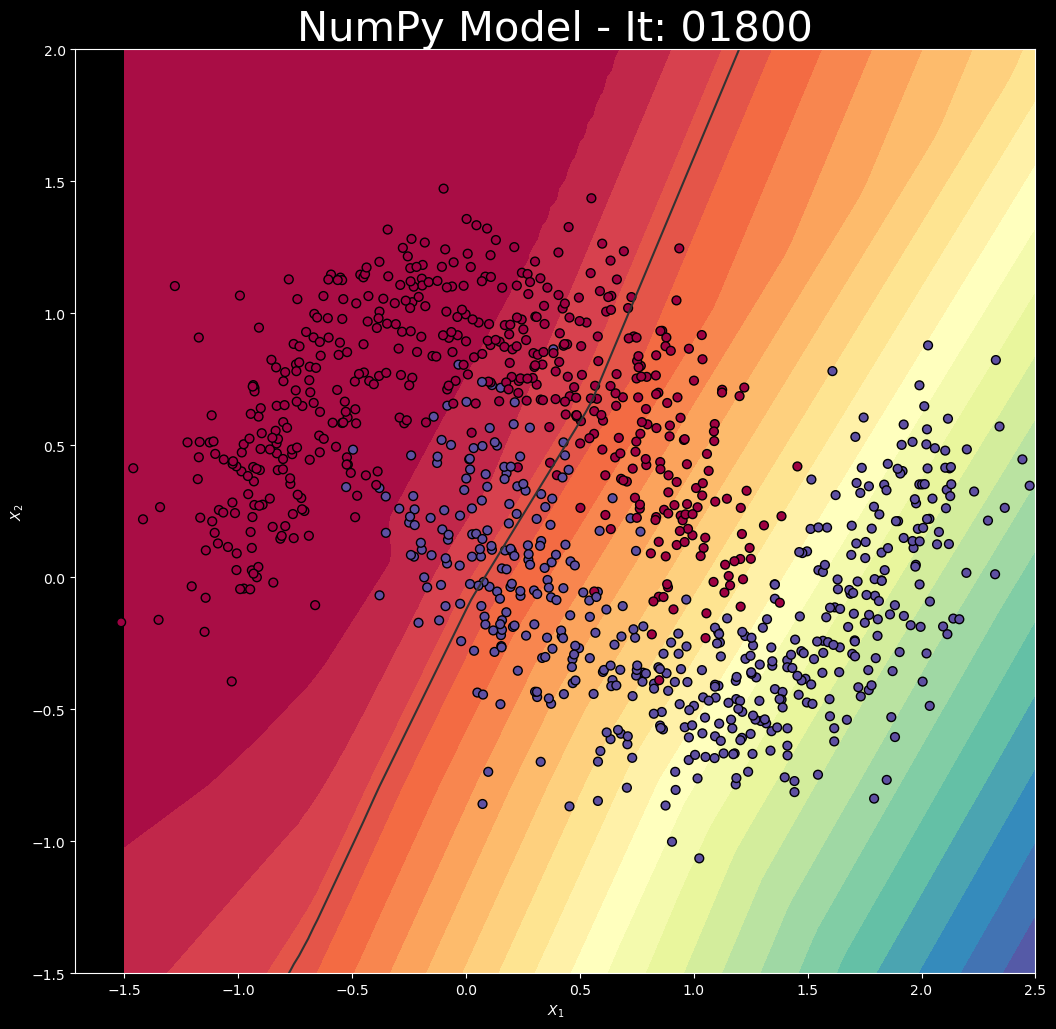

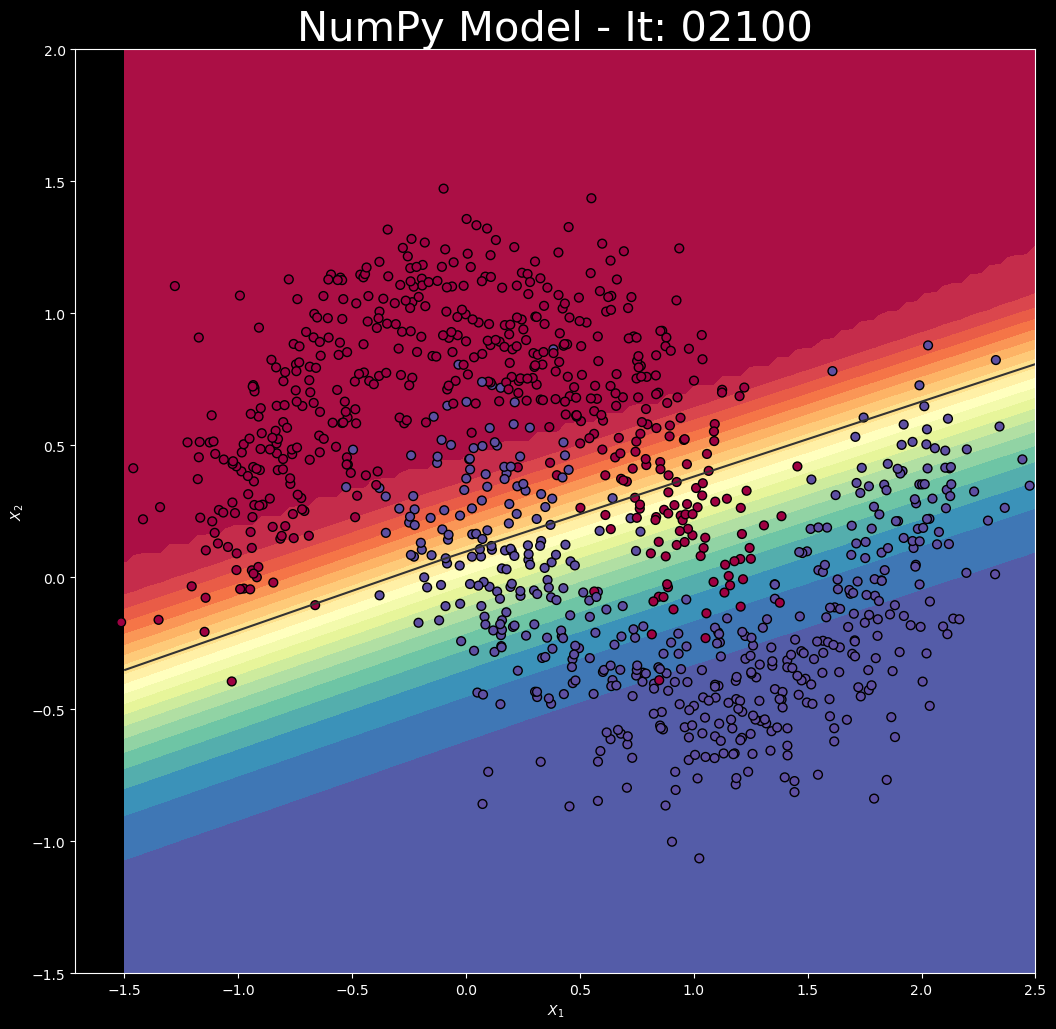

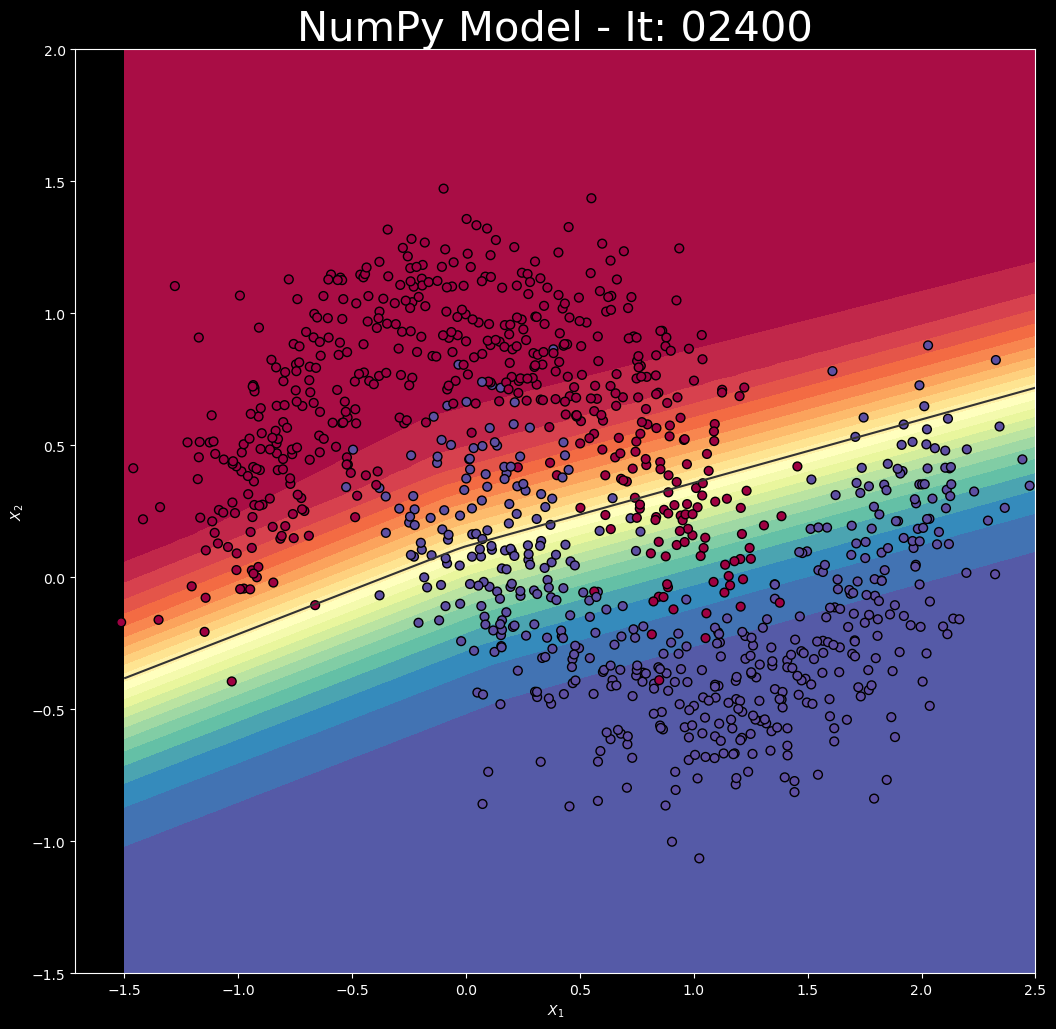

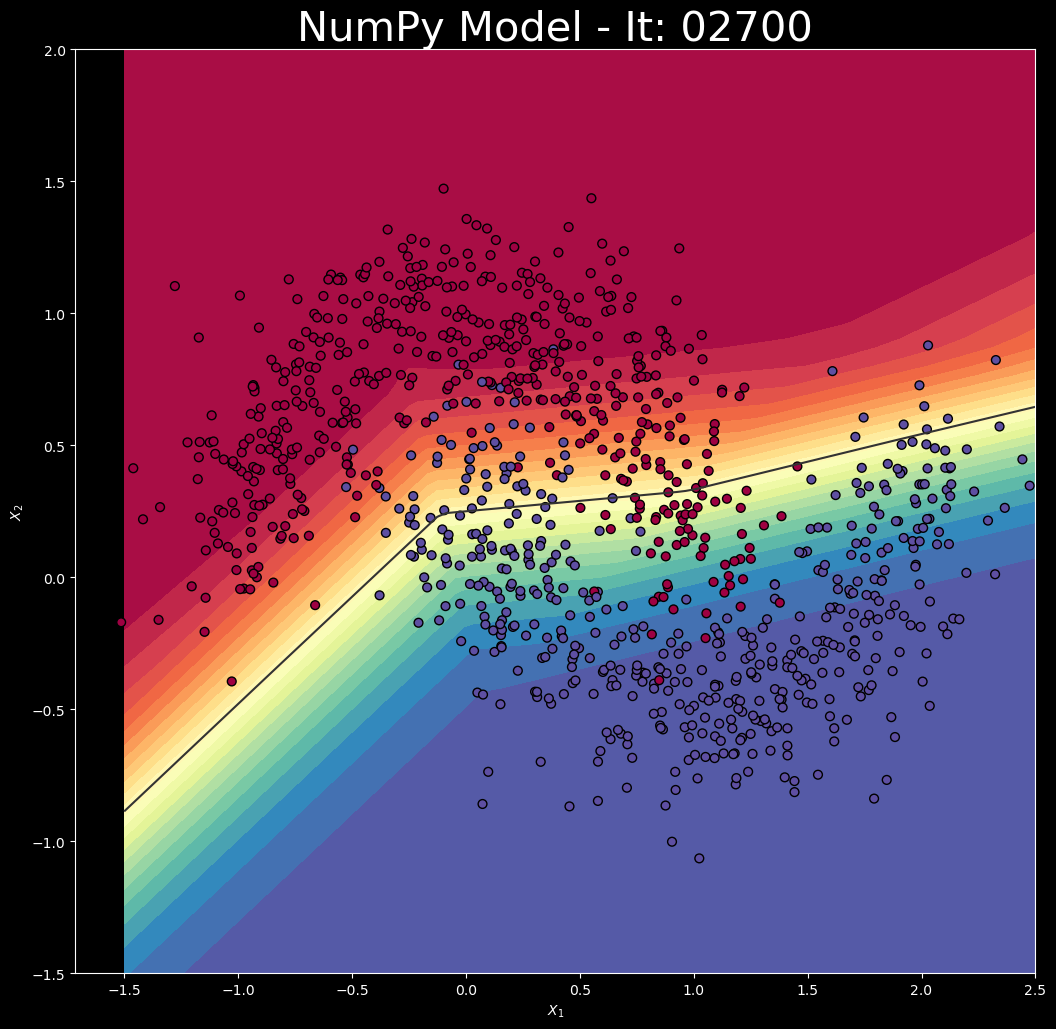

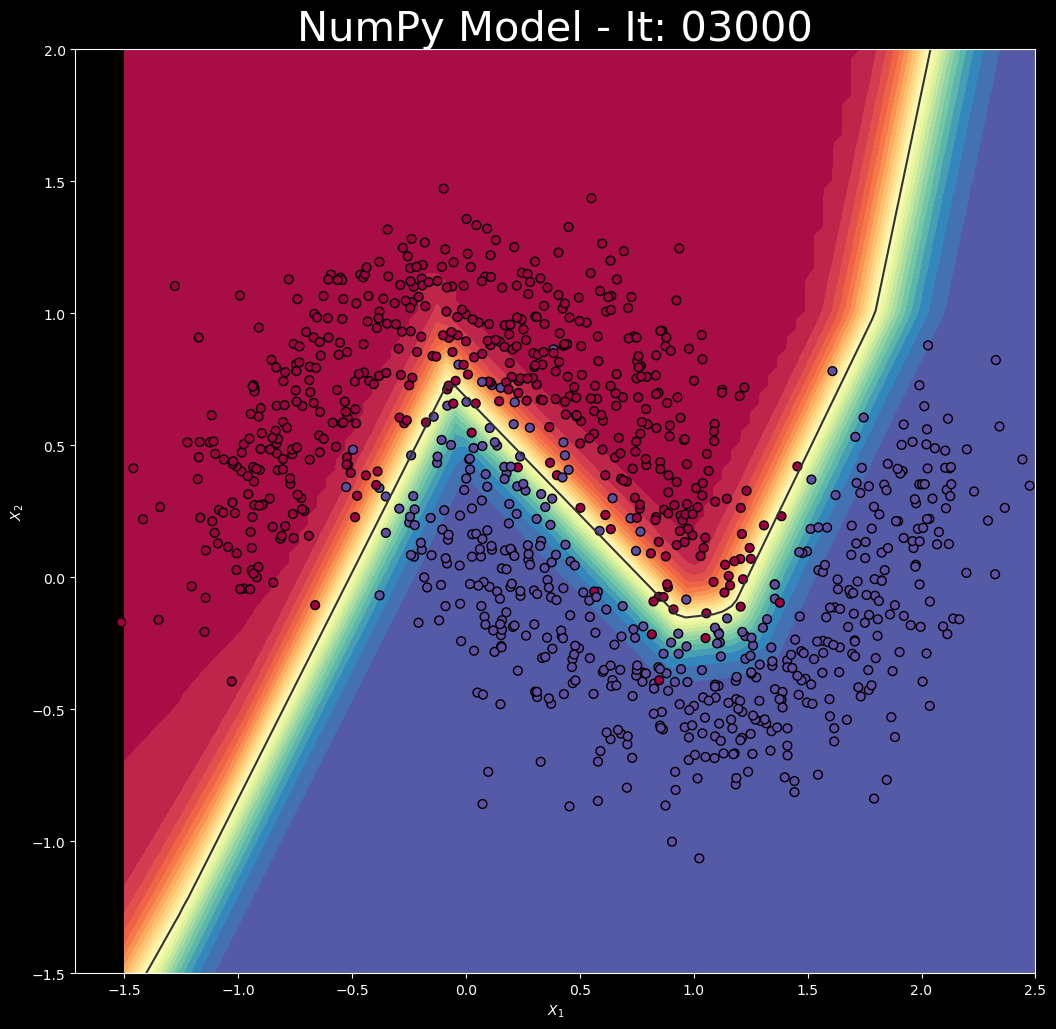

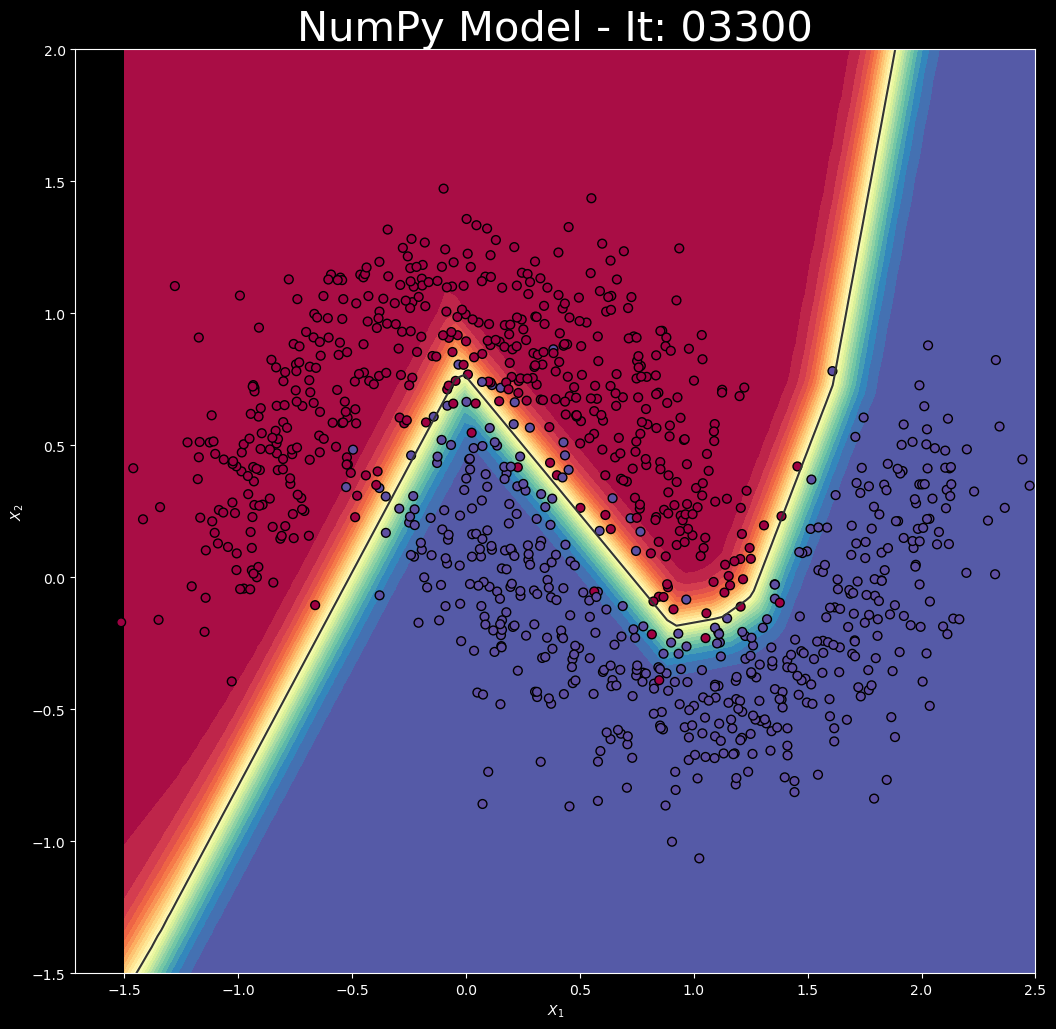

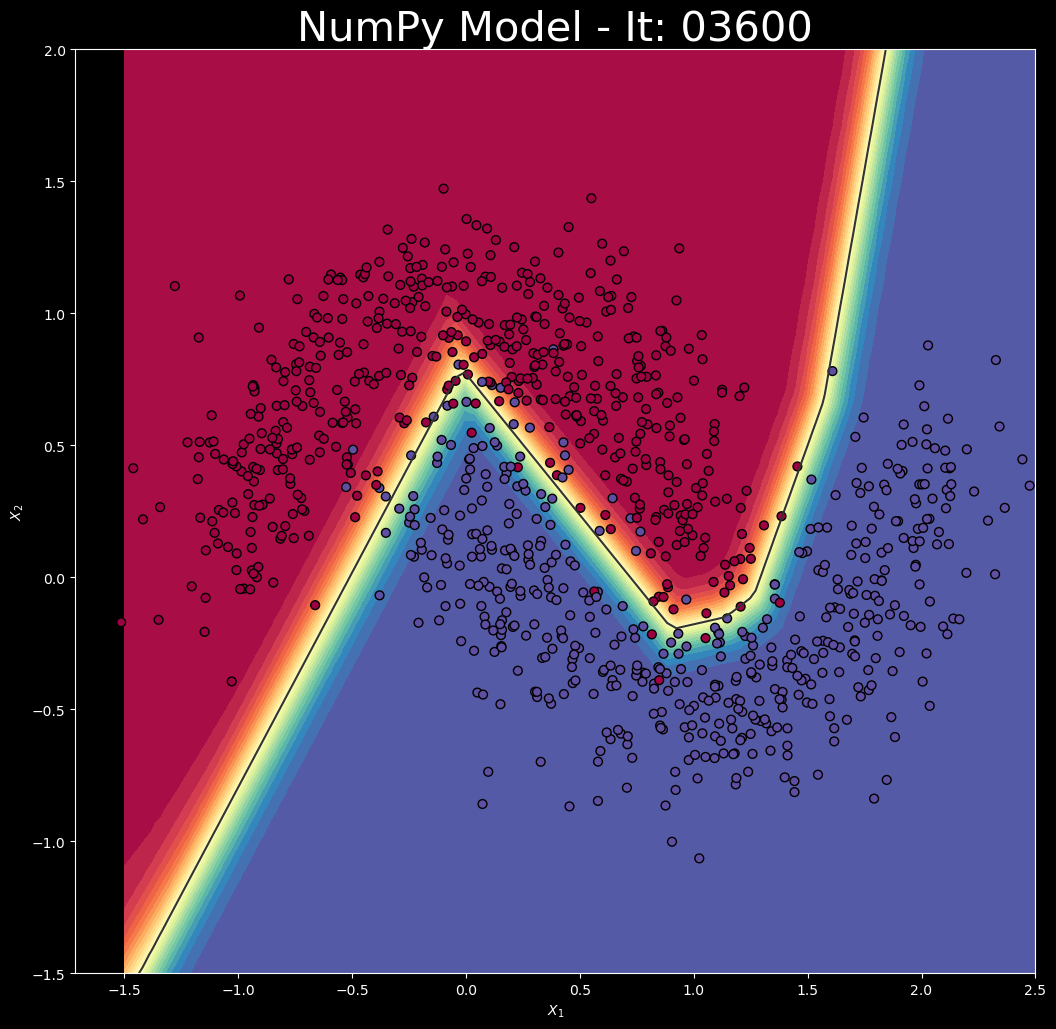

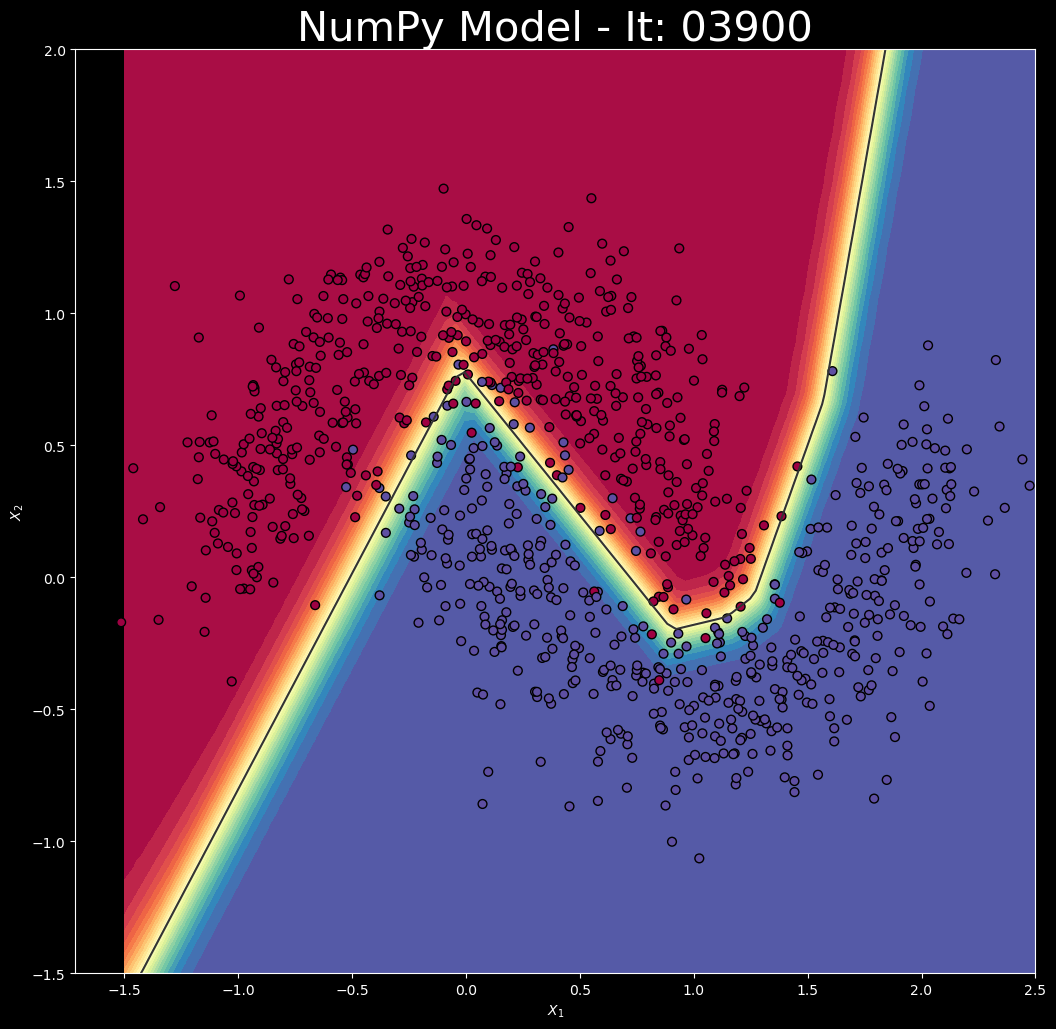

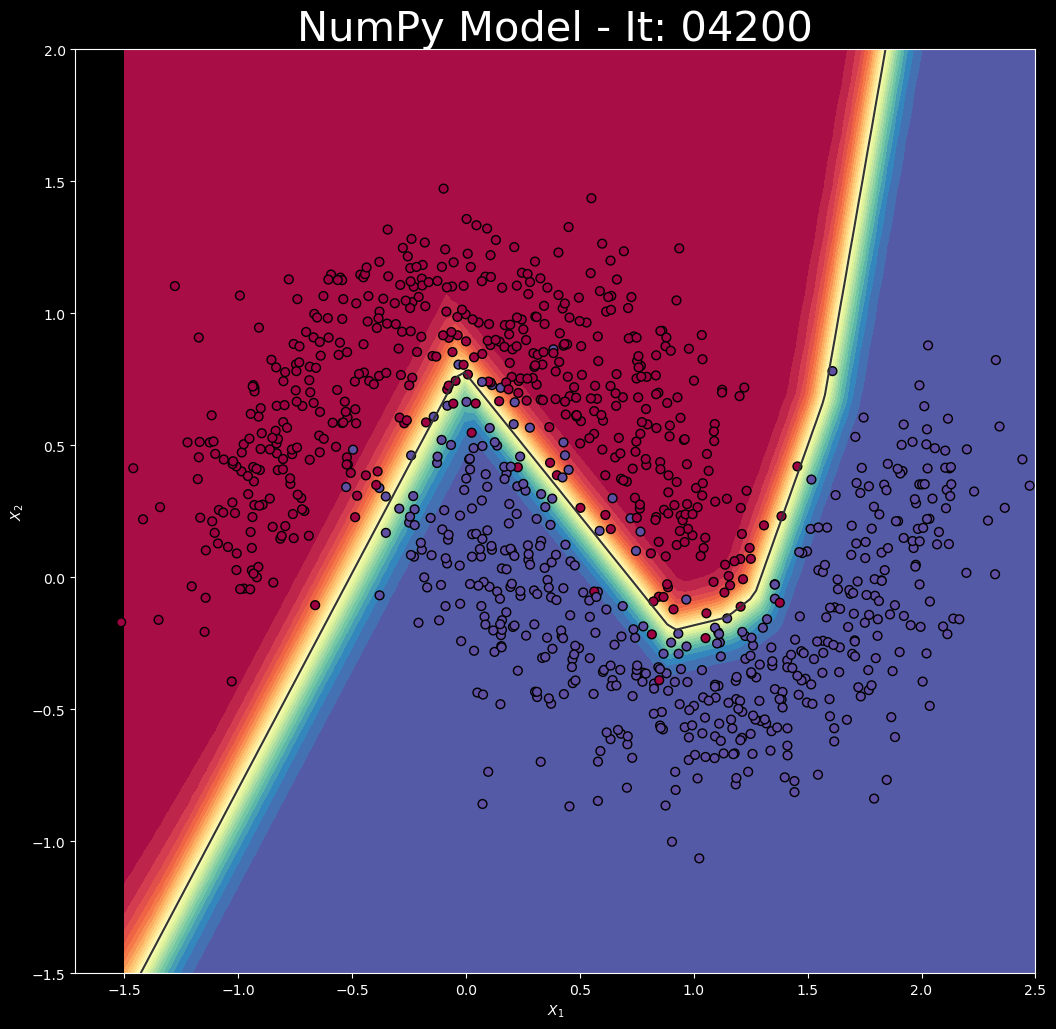

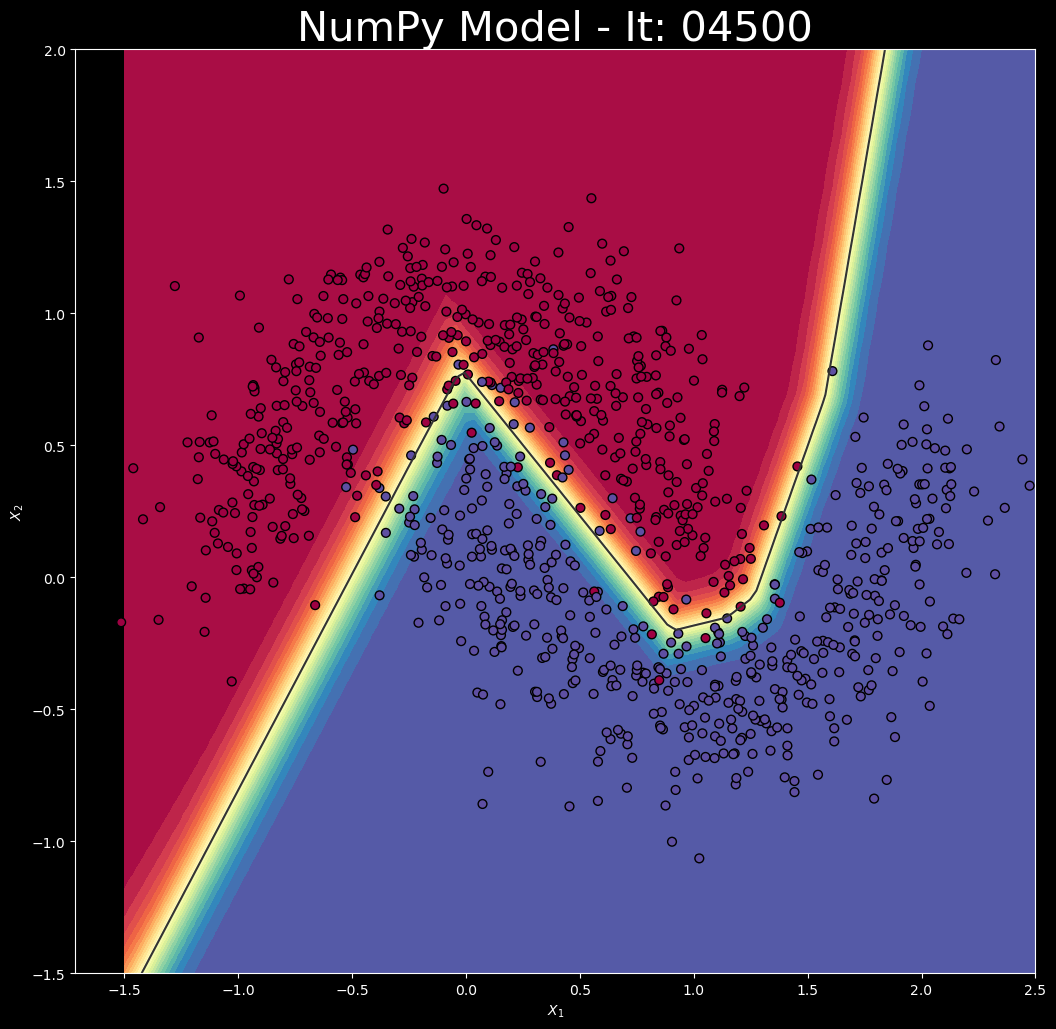

In [243]:
# Training
params_values, cost, acc = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), nn_architecture, 4500, 0.1, True, callback_numpy_plot)

In [244]:
params_values

{'W1': array([[ 0.97760299, -0.19565751],
        [-1.37671578, -0.29632411],
        [-0.5703431 , -0.53519989],
        [-0.10000137, -0.43075567],
        [-0.53255962, -0.24707838]]),
 'b1': array([[-0.92516198],
        [ 0.20654035],
        [ 0.68400329],
        [ 0.45183777],
        [ 0.57256391]]),
 'W2': array([[ 7.29459810e-01, -6.82559043e-01,  3.95176661e-01,
          1.53669985e-01,  4.44454002e-01],
        [-1.06352937e-01, -4.48173125e-02, -1.06437217e-01,
         -4.92039417e-04,  5.32723597e-02],
        [-1.76358794e-01,  2.48287731e-01,  6.98249369e-02,
          9.60317032e-02,  5.43460630e-02],
        [-6.83708551e-02, -1.23169222e-02, -9.38286978e-02,
         -2.68176422e-02,  5.22006452e-02],
        [-6.91660752e-02, -3.96753527e-02, -6.87172700e-02,
         -8.45205641e-02, -6.71246131e-02],
        [ 7.79415937e-01, -8.72733027e-01,  5.53455263e-01,
          4.28170594e-01,  4.77228307e-01],
        [ 4.71086116e-01, -5.30755443e-01,  2.82311984e-01,